In [17]:
import pandas as pd
import os
from pathlib import Path

In [1]:
# ============================================
# STEP 1: Load and validate OHLCV data
# ============================================
import pandas as pd
import numpy as np
from pathlib import Path

# Load single stock for testing
df = pd.read_parquet('/opt/uni2ts/data/processed_equities/5m/A.parquet')

print(f"Data shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Time range: {df.ts.min()} to {df.ts.max()}")

# Validate data quality
assert df.columns.tolist() == ['ts', 'open', 'high', 'low', 'close', 'volume'], "Unexpected columns"
assert df['volume'].min() >= 0, "Volume contains negative values"
assert (df['low'] <= df['high']).all(), "Invalid OHLC: low > high"
assert (df['low'] <= df['open']).all() & (df['open'] <= df['high']).all(), "Invalid OHLC: open outside range"
assert (df['low'] <= df['close']).all() & (df['close'] <= df['high']).all(), "Invalid OHLC: close outside range"

# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")


Data shape: (499333, 6)
Columns: ['ts', 'open', 'high', 'low', 'close', 'volume']
Time range: 2000-01-03 14:30:00+00:00 to 2025-07-25 19:55:00+00:00
Missing values:
ts        0
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [10]:
df

,ts,open,high,low,close,volume
0,2000-01-03 14:30:00+00:00,56.3305,56.3305,56.3305,56.3305,146510.0
1,2000-01-03 14:35:00+00:00,56.3305,56.4646,55.7940,56.1069,98559.0
2,2000-01-03 14:40:00+00:00,56.2411,56.2411,55.3022,55.4363,106667.0
3,2000-01-03 14:45:00+00:00,55.4810,55.5705,54.7210,54.8104,79687.0
4,2000-01-03 14:50:00+00:00,54.8552,54.8552,54.0057,54.0057,74653.0
...,...,...,...,...,...,...
499328,2025-07-25 19:35:00+00:00,120.9500,121.0100,120.8700,120.9150,8688.0
499329,2025-07-25 19:40:00+00:00,120.8950,120.9750,120.7500,120.7700,15738.0
499330,2025-07-25 19:45:00+00:00,120.7700,120.7700,120.5900,120.6400,19482.0
499331,2025-07-25 19:50:00+00:00,120.6200,120.6850,120.2000,120.3000,44409.0


In [ ]:
# ============================================
# STEP 1: Create custom OHLCV data builder prototype
# ============================================
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Generator, Any
from datasets import Features, Sequence, Value
from datasets import Dataset as HFDataset

def create_ohlcv_dataset_with_gaps(
    df: pd.DataFrame,
    freq: str = '5min',
    market_open_hour: int = 9,
    market_open_minute: int = 30,
    market_close_hour: int = 16,
    market_close_minute: int = 0,
    timezone: str = 'America/New_York',
) -> Generator[dict[str, Any], None, None]:
    """
    Create OHLCV dataset with gap handling and time features.
    
    Args:
        df: DataFrame with columns [ts, open, high, low, close, volume]
        freq: Frequency of the data (e.g., '5min')
        market_open_hour: Hour when market opens (9 for 9:30 AM)
        market_open_minute: Minute when market opens (30 for 9:30 AM)
        market_close_hour: Hour when market closes (16 for 4:00 PM)
        market_close_minute: Minute when market closes (0 for 4:00 PM)
        timezone: Timezone for market hours
    
    Yields:
        Dictionary with dataset entry for each stock
    """
    # Ensure ts is datetime
    df = df.copy()
    df['ts'] = pd.to_datetime(df['ts'])
    
    # Get unique stocks (item_ids)
    # For single stock, we use the filename or a fixed ID
    item_id = 'A'  # For single stock testing
    
    # Create complete time range (including gaps)
    start_time = df['ts'].min()
    end_time = df['ts'].max()
    
    # Create complete time index at specified frequency
    complete_time_index = pd.date_range(
        start=start_time,
        end=end_time,
        freq=freq,
        tz='UTC'  # Keep in UTC for consistency
    )
    
    # Create a complete DataFrame with all timestamps
    complete_df = pd.DataFrame({'ts': complete_time_index})
    
    # Merge with actual data (this creates NaN for gaps)
    complete_df = complete_df.merge(df, on='ts', how='left')
    
    # Add time features
    complete_df['ts_local'] = complete_df['ts'].dt.tz_convert(timezone)
    
    # Minutes since market open (0-390 for 6.5 hour trading day)
    complete_df['hour'] = complete_df['ts_local'].dt.hour
    complete_df['minute'] = complete_df['ts_local'].dt.minute
    complete_df['day_of_week'] = complete_df['ts_local'].dt.dayofweek  # 0=Monday, 6=Sunday
    
    # Calculate minutes since market open
    market_open_minutes = market_open_hour * 60 + market_open_minute
    complete_df['minutes_since_open'] = (
        complete_df['hour'] * 60 + complete_df['minute'] - market_open_minutes
    )
    
    # Set to NaN for non-market hours
    is_market_hours = (
        (complete_df['day_of_week'] < 5) &  # Monday-Friday
        (complete_df['hour'] >= market_open_hour) &
        (complete_df['hour'] < market_close_hour) &
        ~((complete_df['hour'] == market_close_hour) & (complete_df['minute'] >= market_close_minute))
    )
    
    complete_df.loc[~is_market_hours, 'minutes_since_open'] = np.nan
    
    # Normalize time features to [0, 1] range
    complete_df['minutes_since_open_norm'] = (complete_df['minutes_since_open'] - 195.0) / 97.5  # 390 minutes in trading day
    complete_df['day_of_week_norm'] = complete_df['day_of_week'] - 2 # 0-6 -> 0-1
    
    # Prepare target and features
    target = complete_df['close'].values
    past_feat_dynamic_real = np.stack([
        complete_df['open'].values,
        complete_df['high'].values,
        complete_df['low'].values,
        complete_df['volume'].values,
        complete_df['minutes_since_open_norm'].values,  # Time feature 0
        complete_df['day_of_week_norm'].values,        # Time feature 1
    ], axis=0)  # Shape: [6, time_steps]
    
    # Create observed mask (1 for observed, 0 for missing/gaps)
    observed_mask = ~complete_df['close'].isna().values
    
    yield {
        'item_id': item_id,
        'start': start_time,
        'freq': freq,
        'target': target,
        'past_feat_dynamic_real': past_feat_dynamic_real,
        'observed_mask': observed_mask.astype(np.float32),
    }

# Test the data builder
df = pd.read_parquet('/opt/uni2ts/data/processed_equities/5m/A.parquet')

# Create dataset
dataset_gen = create_ohlcv_dataset_with_gaps(df, freq='5min')

# Get first (and only) item
dataset_entry = next(dataset_gen)

print(f"Dataset entry created successfully")
print(f"  item_id: {dataset_entry['item_id']}")
print(f"  start: {dataset_entry['start']}")
print(f"  freq: {dataset_entry['freq']}")
print(f"  target shape: {dataset_entry['target'].shape}")
print(f"  past_feat_dynamic_real shape: {dataset_entry['past_feat_dynamic_real'].shape}")
print(f"  observed_mask shape: {dataset_entry['observed_mask'].shape}")

# Check for gaps
num_gaps = np.sum(dataset_entry['observed_mask'] == 0)
total_points = len(dataset_entry['observed_mask'])
print(f"\nGap analysis:")
print(f"  Total points: {total_points}")
print(f"  Observed points: {np.sum(dataset_entry['observed_mask'] == 1)}")
print(f"  Gap points: {num_gaps}")
print(f"  Gap percentage: {num_gaps / total_points * 100:.2f}%")


Dataset entry created successfully
  item_id: A
  start: 2000-01-03 14:30:00+00:00
  freq: 5min
  target shape: (2688546,)
  past_feat_dynamic_real shape: (6, 2688546)
  observed_mask shape: (2688546,)

Gap analysis:
  Total points: 2688546
  Observed points: 499333
  Gap points: 2189213
  Gap percentage: 81.43%


In [20]:
dataset_entry

{'item_id': 'A',
 'start': Timestamp('2000-01-03 14:30:00+0000', tz='UTC'),
 'freq': '5min',
 'target': array([ 56.3305,  56.1069,  55.4363, ..., 120.64  , 120.3   , 120.24  ]),
 'past_feat_dynamic_real': array([[5.63305000e+01, 5.63305000e+01, 5.62411000e+01, ...,
         1.20770000e+02, 1.20620000e+02, 1.20295000e+02],
        [5.63305000e+01, 5.64646000e+01, 5.62411000e+01, ...,
         1.20770000e+02, 1.20685000e+02, 1.20379000e+02],
        [5.63305000e+01, 5.57940000e+01, 5.53022000e+01, ...,
         1.20590000e+02, 1.20200000e+02, 1.20090000e+02],
        [1.46510000e+05, 9.85590000e+04, 1.06667000e+05, ...,
         1.94820000e+04, 4.44090000e+04, 1.72961000e+05],
        [0.00000000e+00, 1.28205128e-02, 2.56410256e-02, ...,
         9.61538462e-01, 9.74358974e-01, 9.87179487e-01],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.66666667e-01, 6.66666667e-01, 6.66666667e-01]]),
 'observed_mask': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)}

/tmp/ipykernel_5525/3772763740.py:32: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/opt/uni2ts/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


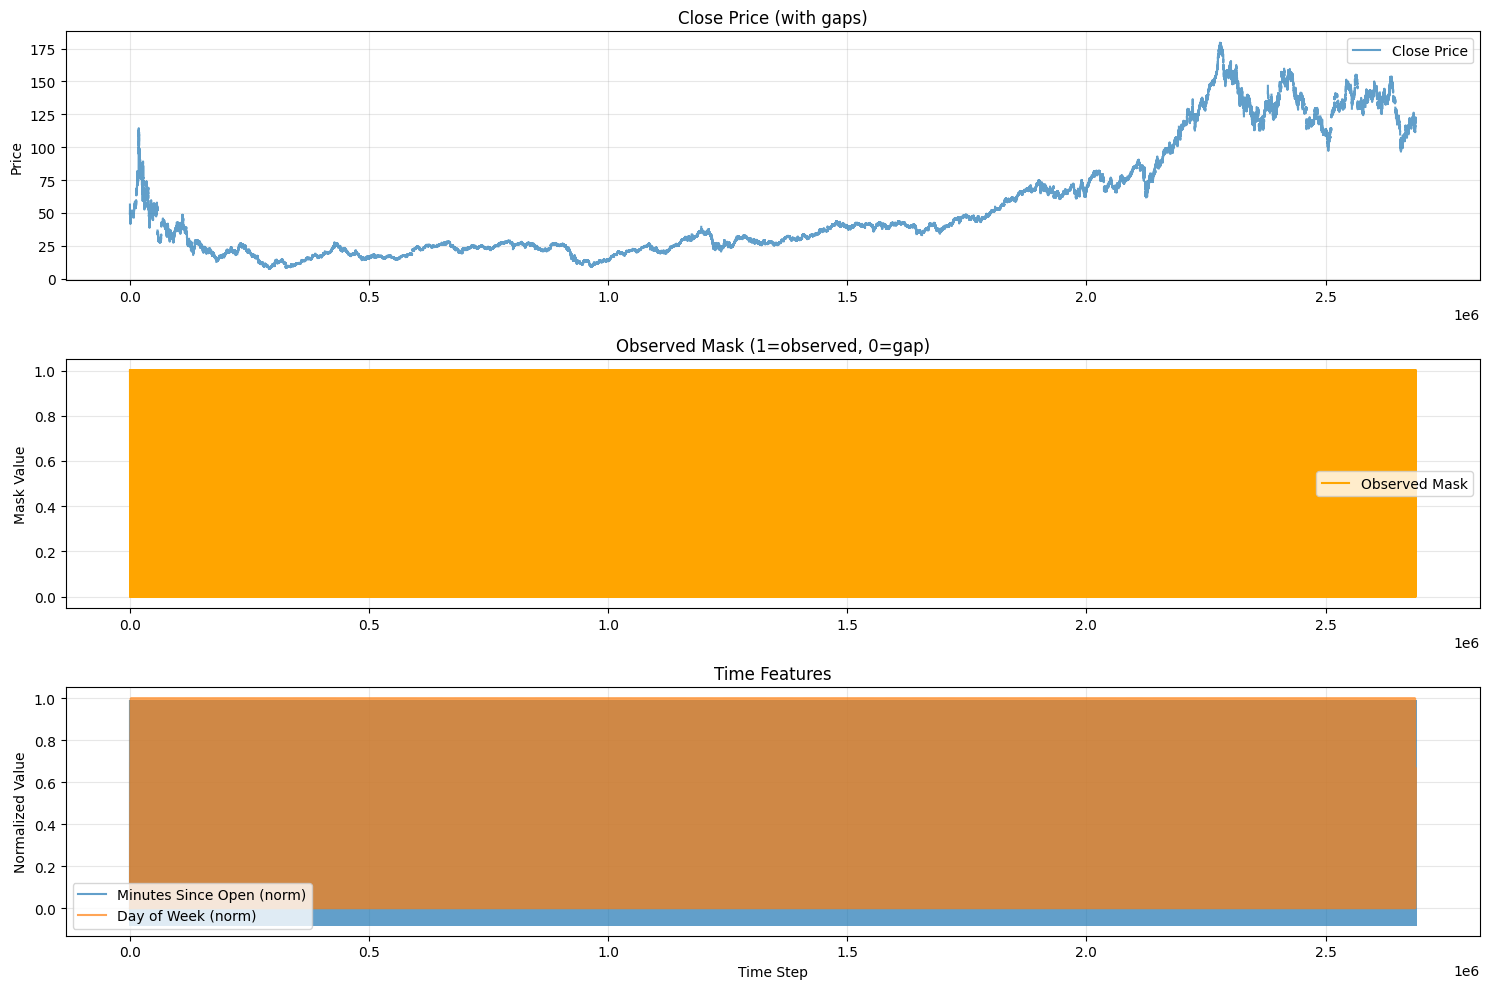

In [21]:
# ============================================
# STEP 2: Visualize the data structure
# ============================================
import matplotlib.pyplot as plt

# Create a visualization of the data with gaps
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Plot 1: Close price with gaps
axes[0].plot(dataset_entry['target'], label='Close Price', alpha=0.7)
axes[0].set_title('Close Price (with gaps)')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Observed mask
axes[1].plot(dataset_entry['observed_mask'], label='Observed Mask', color='orange')
axes[1].set_title('Observed Mask (1=observed, 0=gap)')
axes[1].set_ylabel('Mask Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Time features
axes[2].plot(dataset_entry['past_feat_dynamic_real'][4], label='Minutes Since Open (norm)', alpha=0.7)
axes[2].plot(dataset_entry['past_feat_dynamic_real'][5], label='Day of Week (norm)', alpha=0.7)
axes[2].set_title('Time Features')
axes[2].set_ylabel('Normalized Value')
axes[2].set_xlabel('Time Step')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [32]:
dataset_entry['past_feat_dynamic_real'][4]

array([0.        , 0.01282051, 0.02564103, ..., 0.96153846, 0.97435897,
       0.98717949])

In [ ]:
# ============================================
# STEP 3: Test GroupedPackedStdScaler with OHLCV
# ============================================
import torch
from einops import rearrange
from uni2ts.module.packed_scaler import GroupedPackedStdScaler

# Get sample data
sample = dataset_list[0]
target = sample['target']  # Shape: [time_steps]
past_feat = sample['past_feat_dynamic_real']  # Shape: [4, time_steps]

print(f"\nTarget shape: {target.shape}")  # Should be [time_steps]
print(f"Past features shape: {past_feat.shape}")  # Should be [4, time_steps]

# Combine for scaling (OHLCV together)
# We need to scale: close (target) + open, high, low, volume (past features)
# Group mapping: [0,0,0,0,1] for [open, high, low, close, volume]

# Combine all 5 variates for scaling
ohlcv_combined = np.stack([
    past_feat[0],  # open
    past_feat[1],  # high
    past_feat[2],  # low
    target,         # close
    past_feat[3],  # volume
], axis=0)  # Shape: [5, time_steps]

# Convert to tensor and add patch dimension
ohlcv_tensor = torch.tensor(ohlcv_combined, dtype=torch.float32).unsqueeze(-1)  # [5, time, 1]

# Reshape to packed format: [time, dim, patch] -> [(dim * time), patch]
time_steps = ohlcv_tensor.shape[0]
num_variates = ohlcv_tensor.shape[1]
patch_size = 1  # For testing without patching

target_packed = rearrange(
    ohlcv_tensor,
    "time dim patch -> (dim time) patch",
    dim=num_variates,
    time=time_steps
)

# Create group mapping: [0,0,0,0,1] for OHLCV
group_mapping = torch.tensor([0, 0, 0, 0, 1])

# Create required masks
observed_mask = torch.ones_like(target_packed, dtype=torch.bool)
sample_id = torch.ones(target_packed.shape[0], dtype=torch.long)
variate_id = torch.tensor([0]*time_steps + [1]*time_steps + [2]*time_steps + [3]*time_steps + [4]*time_steps, dtype=torch.long)

# Initialize scaler
scaler = GroupedPackedStdScaler(
    group_mapping=group_mapping,
    correction=1,
    minimum_scale=1e-5
)

# Add batch dimension
target_batch = target_packed.unsqueeze(0)
observed_mask_batch = observed_mask.unsqueeze(0)
sample_id_batch = sample_id.unsqueeze(0)
variate_id_batch = variate_id.unsqueeze(0)

# Get location and scale
loc, scale = scaler(
    target=target_batch,
    observed_mask=observed_mask_batch,
    sample_id=sample_id_batch,
    variate_id=variate_id_batch
)

print(f"\nLocation (mean) shape: {loc.shape}")
print(f"Scale (std) shape: {scale.shape}")

# Verify OHLC have same statistics
print(f"\nOHLC means (should be equal):")
for i in range(4):
    print(f"  Variate {i} ({['Open', 'High', 'Low', 'Close'][i]}): {loc[0, i*time_steps, 0].item():.4f}")
print(f"Volume mean: {loc[0, 4*time_steps, 0].item():.4f}")

print(f"\nOHLC stds (should be equal):")
for i in range(4):
    print(f"  Variate {i} ({['Open', 'High', 'Low', 'Close'][i]}): {scale[0, i*time_steps, 0].item():.4f}")
print(f"Volume std: {scale[0, 4*time_steps, 0].item():.4f}")


PandasDataset<size=5, freq=5min, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [ ]:
# ============================================
# STEP 4: Save dataset for fine-tuning
# ============================================
from datasets import Dataset as HFDataset
from datasets import Features, Sequence, Value

# Convert to HuggingFace format
hf_data = {
    'item_id': [sample['item_id'] for sample in dataset_list],
    'start': [sample['start'] for sample in dataset_list],
    'freq': [sample['freq'] for sample in dataset_list],
    'target': [sample['target'].tolist() for sample in dataset_list],
    'past_feat_dynamic_real': [sample['past_feat_dynamic_real'].tolist() for sample in dataset_list],
}

features = Features({
    'item_id': Value('string'),
    'start': Value('timestamp[s]'),
    'freq': Value('string'),
    'target': Sequence(Value('float32')),
    'past_feat_dynamic_real': Sequence(Sequence(Value('float32'))),
})

hf_dataset = HFDataset.from_dict(hf_data, features=features)

# Save to disk
output_path = Path('/opt/uni2ts/data/ohlcv_5m_single_stock')
hf_dataset.save_to_disk(str(output_path))

print(f"\nDataset saved to {output_path}")
print(f"Total items: {len(hf_dataset)}")


In [ ]:
# Magic bash
%%bash

# Activate virtual environment (CRITICAL!)
source venv/bin/activate

# Run fine-tuning with single stock
python -m cli.train \
  -cp cli/conf/finetune \
  exp_name=ohlcv_test \
  run_name=single_stock_test \
  model=moirai_1.1_R_ohlcv \
  data=ohlcv_5m_single_stock \
  trainer.max_epochs=5 \
  trainer.accelerator=gpu \
  trainer.precision=16


In [3]:
daily_df = pd.read_parquet('/opt/uni2ts/data/processed_equities/1d/A.parquet')
daily_df

,ts,open,high,low,close,volume
0,2000-01-03 21:00:00+00:00,56.3305,56.4646,48.1938,51.2786,4538605.0
1,2000-01-04 21:00:00+00:00,48.7303,49.2668,46.3162,46.9421,4691419.0
2,2000-01-05 21:00:00+00:00,47.3891,47.3891,43.1420,44.7067,5661344.0
3,2000-01-06 21:00:00+00:00,44.0808,44.3491,41.5773,42.0690,2495851.0
4,2000-01-07 21:00:00+00:00,42.2479,47.1656,42.2031,46.4950,2741187.0
...,...,...,...,...,...,...
6424,2025-07-21 20:00:00+00:00,113.2300,113.6600,110.7500,112.0400,1121087.0
6425,2025-07-22 20:00:00+00:00,112.8500,117.0500,112.1400,116.2500,875196.0
6426,2025-07-23 20:00:00+00:00,119.3800,120.7900,117.4800,119.4800,1028959.0
6427,2025-07-24 20:00:00+00:00,119.4300,122.7500,119.4300,120.3500,848002.0


In [3]:
m5_df = pd.read_parquet('/opt/uni2ts/data/processed_equities/5m/A.parquet')
m5_df

,ts,open,high,low,close,volume
0,2000-01-03 14:30:00+00:00,56.3305,56.3305,56.3305,56.3305,146510.0
1,2000-01-03 14:35:00+00:00,56.3305,56.4646,55.7940,56.1069,98559.0
2,2000-01-03 14:40:00+00:00,56.2411,56.2411,55.3022,55.4363,106667.0
3,2000-01-03 14:45:00+00:00,55.4810,55.5705,54.7210,54.8104,79687.0
4,2000-01-03 14:50:00+00:00,54.8552,54.8552,54.0057,54.0057,74653.0
...,...,...,...,...,...,...
499328,2025-07-25 19:35:00+00:00,120.9500,121.0100,120.8700,120.9150,8688.0
499329,2025-07-25 19:40:00+00:00,120.8950,120.9750,120.7500,120.7700,15738.0
499330,2025-07-25 19:45:00+00:00,120.7700,120.7700,120.5900,120.6400,19482.0
499331,2025-07-25 19:50:00+00:00,120.6200,120.6850,120.2000,120.3000,44409.0


In [4]:
import pandas as pd
import numpy as np
from gluonts.dataset.pandas import PandasDataset

# Load one file (start with A.parquet from your notebook)
df = m5_df
print(df.columns)  # Index(['ts', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


Index(['ts', 'open', 'high', 'low', 'close', 'volume'], dtype='object')


In [16]:
def prepare_ohlcv_for_moirai(df, item_id='AAPL', time_col='ts'):
    """
    Convert wide OHLCV format to long format for MOIRAI covariates.
    
    Args:
        df: DataFrame with columns [ts, open, high, low, close, volume]
            ts should be UTC timestamps representing market hours
        item_id: Identifier for this time series (stock symbol)
        time_col: Name of timestamp column
    
    Returns:
        Long format DataFrame ready for PandasDataset.from_long_dataframe()
    """
    
    # Ensure ts is datetime
    if not pd.api.types.is_datetime64_any_dtype(df[time_col]):
        df = df.copy()
        df[time_col] = pd.to_datetime(df[time_col])
    
    # Calculate minutes since market open (9:30 AM ET ≈ 14:30 UTC)
    market_open_utc = df[time_col].dt.normalize() + pd.Timedelta(hours=14, minutes=30)
    minutes_since_open = (df[time_col] - market_open_utc).dt.total_seconds() / 60
    minutes_since_open = minutes_since_open.clip(lower=0)
    
    # Create DataFrame with features, keeping timestamp as column
    df_long = pd.DataFrame({
        time_col: df[time_col],  # Include timestamp column
        'target': df['close'].values,  # Predict Close only
        
        # Historical OHLCV (lagged by 1 bar to avoid using current bar's data)
        'past_feat_dynamic_real_0': df['open'].shift(1).fillna(0).values,   # Past Open
        'past_feat_dynamic_real_1': df['high'].shift(1).fillna(0).values,   # Past High  
        'past_feat_dynamic_real_2': df['low'].shift(1).fillna(0).values,    # Past Low
        'past_feat_dynamic_real_3': df['volume'].shift(1).fillna(0).values, # Past Volume
        
        # Calendar/features known at inference time (future-known)
        'feat_dynamic_real_0': minutes_since_open.values,      # Minutes since market open
        'feat_dynamic_real_1': df[time_col].dt.dayofweek.values, # Day of week (0-6)
        'feat_dynamic_real_2': df[time_col].dt.month.values, 
        
        'item_id': item_id  # Required by GluonTS
    })
    
    # Sort by timestamp to ensure proper ordering
    df_long = df_long.sort_values(time_col).reset_index(drop=True)
    
    return df_long


import pandas as pd
from gluonts.dataset.pandas import PandasDataset

# Load your 5m data
df = pd.read_parquet('/opt/uni2ts/data/processed_equities/5m/A.parquet')

# Prepare for MOIRAI
df_long = prepare_ohlcv_for_moirai(df, item_id='A')

display(df_long.head(3))

# Create dataset
ds = PandasDataset.from_long_dataframe(
    df_long,
    timestamp='ts',  # Specify timestamp column name
    target='target',
    past_feat_dynamic_real=[f'past_feat_dynamic_real_{i}' for i in range(4)],
    feat_dynamic_real=[f'feat_dynamic_real_{i}' for i in range(4)],
    item_id='item_id',
    freq='5min'  # Explicitly set 5-minute frequency
)

print(f"Dataset created successfully!")
print(f"Frequency set to: 5min")


,ts,target,past_feat_dynamic_real_0,past_feat_dynamic_real_1,past_feat_dynamic_real_2,past_feat_dynamic_real_3,feat_dynamic_real_0,feat_dynamic_real_1,feat_dynamic_real_2,item_id
0,2000-01-03 14:30:00+00:00,56.3305,0.0000,0.0000,0.0000,0.0,0.0,0,1,A
1,2000-01-03 14:35:00+00:00,56.1069,56.3305,56.3305,56.3305,146510.0,5.0,0,1,A
2,2000-01-03 14:40:00+00:00,55.4363,56.3305,56.4646,55.7940,98559.0,10.0,0,1,A


Dataset created successfully!
Frequency set to: 5min


In [10]:
df_long

,target,past_feat_dynamic_real_0,past_feat_dynamic_real_1,past_feat_dynamic_real_2,past_feat_dynamic_real_3,feat_dynamic_real_0,feat_dynamic_real_1,feat_dynamic_real_2,feat_dynamic_real_3,item_id
1970-01-01 00:00:00.000000000,56.3305,0.0000,0.0000,0.0000,0.0,0.0,14,0,1,A
1970-01-01 00:00:00.000000001,56.1069,56.3305,56.3305,56.3305,146510.0,5.0,14,0,1,A
1970-01-01 00:00:00.000000002,55.4363,56.3305,56.4646,55.7940,98559.0,10.0,14,0,1,A
1970-01-01 00:00:00.000000003,54.8104,56.2411,56.2411,55.3022,106667.0,15.0,14,0,1,A
1970-01-01 00:00:00.000000004,54.0057,55.4810,55.5705,54.7210,79687.0,20.0,14,0,1,A
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000499328,120.9150,120.9600,120.9700,120.8968,5321.0,305.0,19,4,1,A
1970-01-01 00:00:00.000499329,120.7700,120.9500,121.0100,120.8700,8688.0,310.0,19,4,1,A
1970-01-01 00:00:00.000499330,120.6400,120.8950,120.9750,120.7500,15738.0,315.0,19,4,1,A
1970-01-01 00:00:00.000499331,120.3000,120.7700,120.7700,120.5900,19482.0,320.0,19,4,1,A


In [18]:
def process_and_save_stock_file(file_path, stock_symbol, output_dir='prepared_data'):
    """
    Process a single stock file and save to disk for lazy loading
    """
    print(f"Processing {stock_symbol}...")
    
    # Create output directory
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    # Load and prepare data
    df = pd.read_parquet(file_path)
    df_long = prepare_ohlcv_for_moirai(df, item_id=stock_symbol)
    
    # Save prepared DataFrame
    output_file = output_path / f"{stock_symbol}_prepared.parquet"
    df_long.to_parquet(output_file, index=False)
    
    print(f"Saved {stock_symbol} to {output_file} ({len(df_long)} rows)")
    return output_file

# Process multiple stocks and save to disk
def process_multiple_stocks(data_dir, output_dir='prepared_data', max_stocks=None):
    """
    Process multiple stock files and save prepared data to disk
    """
    data_path = Path(data_dir)
    files = list(data_path.glob('*.parquet'))
    
    if max_stocks:
        files = files[:max_stocks]
    
    print(f"Processing {len(files)} stocks...")
    
    processed_files = []
    for file_path in files:
        symbol = file_path.stem  # Remove .parquet extension
        output_file = process_and_save_stock_file(file_path, symbol, output_dir)
        processed_files.append((symbol, output_file))
    
    return processed_files

# Usage
processed_files = process_multiple_stocks(
    data_dir='/opt/uni2ts/data/processed_equities/5m/',
    output_dir='/opt/uni2ts/data/prepared_ohlcv_data',
    max_stocks=5  # Process first 5 stocks
)

print(f"Processed {len(processed_files)} stocks")

Processing 5 stocks...
Processing CRS...
Saved CRS to /opt/uni2ts/data/prepared_ohlcv_data/CRS_prepared.parquet (473769 rows)
Processing HPE...
Saved HPE to /opt/uni2ts/data/prepared_ohlcv_data/HPE_prepared.parquet (190129 rows)
Processing FMX...
Saved FMX to /opt/uni2ts/data/prepared_ohlcv_data/FMX_prepared.parquet (472926 rows)
Processing CNI...
Saved CNI to /opt/uni2ts/data/prepared_ohlcv_data/CNI_prepared.parquet (488475 rows)
Processing LPX...
Saved LPX to /opt/uni2ts/data/prepared_ohlcv_data/LPX_prepared.parquet (495423 rows)
Processed 5 stocks
